# Setup

In [42]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from utils import read_csv_non_utf, extract_year

In [43]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [44]:
# Choosing the dataset to explore - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Reading and exploring the dataset

In [45]:
# Checking basic info
num_species = len(data['Species'].unique())
print(f'{num_species} species')

print(f'{len(data)} effect sizes')

num_studies = len(data['Study'].unique())
print(f'{num_studies} studies')

296 species
3281 effect sizes
163 studies


## Exploring taxonomic representation

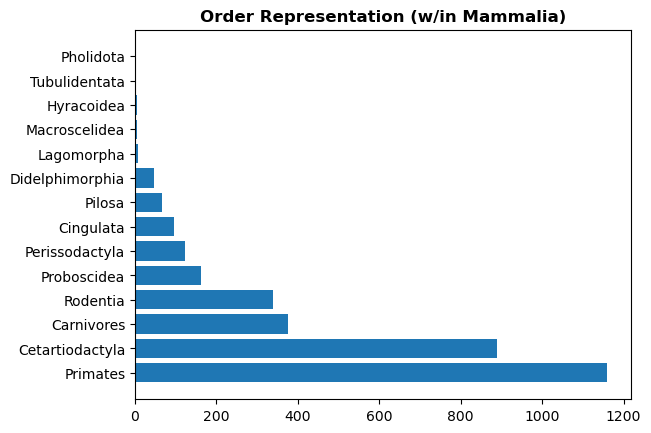

In [46]:
order_counts = data['Order'].value_counts()

plt.barh(order_counts.index, order_counts.values)
plt.title('Order Representation (w/in Mammalia)', weight = 'bold');

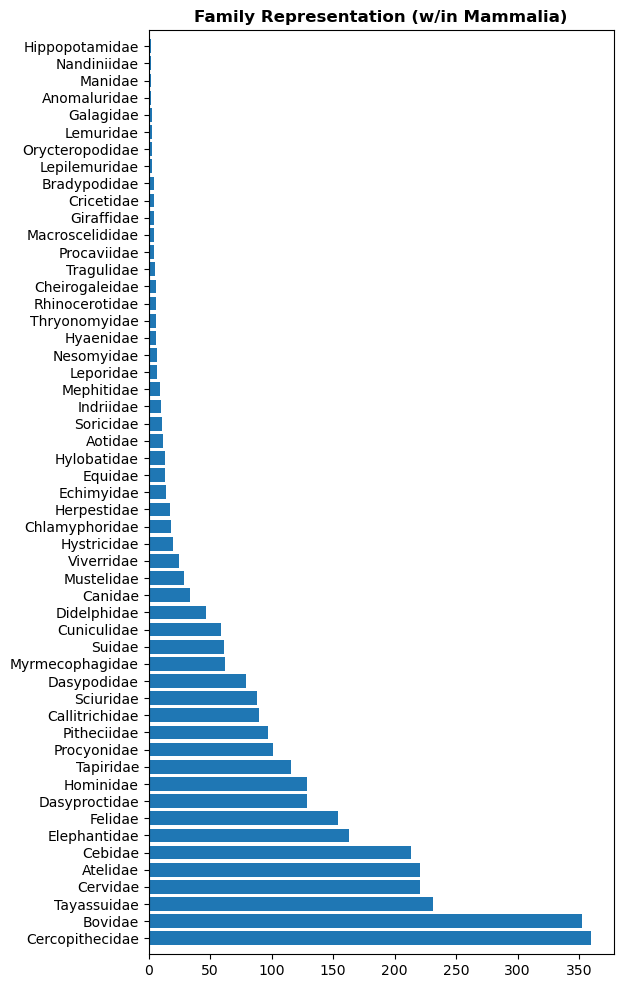

In [47]:
fam_counts = data['Family'].value_counts()

plt.figure(figsize = (6, 12))

plt.barh(fam_counts.index, fam_counts.values)
plt.title('Family Representation (w/in Mammalia)', weight = 'bold')

plt.margins(y = 0.01);

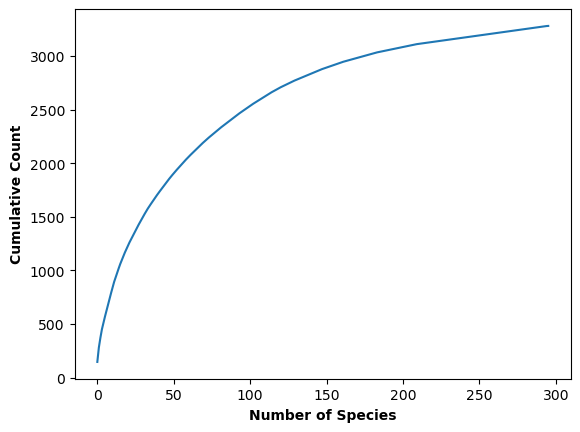

In [48]:
species_counts = data['Species'].value_counts()
species_cumsum = species_counts.to_numpy().cumsum()

plt.plot(species_cumsum)

plt.ylabel('Cumulative Count', weight = 'bold')
plt.xlabel('Number of Species', weight = 'bold');

## Exploring spatial representation

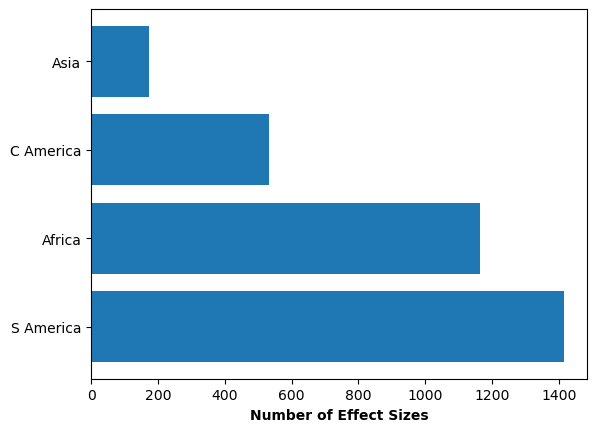

In [49]:
col = 'Region' if dataset == 'mammals' else 'Realm'
region_counts = data[col].value_counts()

plt.barh(region_counts.index, region_counts)
plt.xlabel('Number of Effect Sizes', weight = 'bold');

In [50]:
# Plotting distribution of effect sizes across countries
country_counts = data['Country'].value_counts().to_frame().reset_index()

fig = px.choropleth(country_counts, 
                    locations = 'Country',
                    locationmode = 'country names',
                    color = 'count', 
                    hover_name = 'Country', 
                    color_continuous_scale = px.colors.sequential.Plasma, 
                    width = 1000,
                    height = 500)
fig.show()

In [51]:
# Plotting study locations as a scatterplot
fig = px.scatter_geo(data, 
                     lat = 'Y' if dataset == 'mammals' else 'Latitude',
                     lon = 'X' if dataset == 'mammals' else 'Longitude',
                     hover_name = 'Reference' if dataset == 'mammals' else 'Dataset',
                     color_discrete_sequence = ['maroon'], 
                     width = 1000,
                     height = 500)
fig.show()

# dpi = 400
# fig.write_image('/Users/emiliolr/Desktop/study_sites.png', width = 6 * dpi, height = 3 * dpi, scale = 1)

## Inspecting response variable

In [52]:
# Checking number of extirpation events in the dataset
resp_col = 'ratio' if dataset == 'mammals' else 'RR'
num_non_extirp = (data[resp_col] != 0).sum()
num_extirp = len(data) - num_non_extirp

print(f'{num_extirp} extirpation events ({round(num_extirp / len(data) * 100, 2)}%), {num_non_extirp} non-extirpation events ({round(num_non_extirp / len(data) * 100, 2)}%)')

408 extirpation events (12.44%), 2873 non-extirpation events (87.56%)


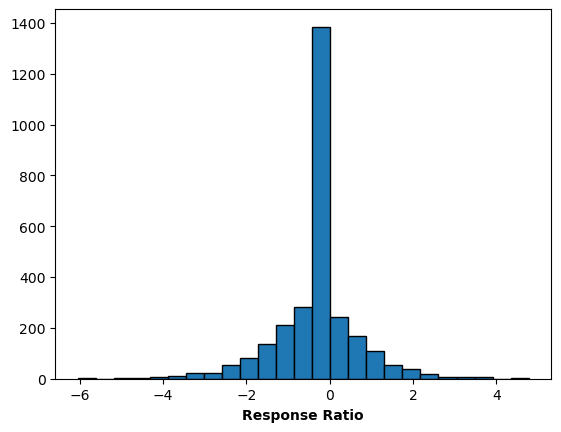

In [53]:
# Plotting a histogram of response ratio
plt.hist(np.log(data[data[resp_col] != 0][resp_col]), bins = 25, edgecolor = 'black')

plt.xlabel('Response Ratio', weight = 'bold');

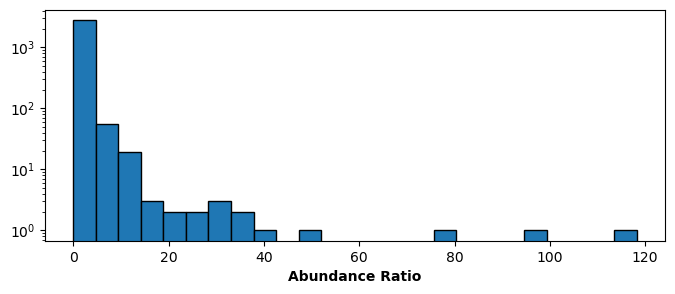

In [54]:
# Plotting a histogram of actual abundance ratios (hunted to unhunted)
plt.figure(figsize = (8, 3))
plt.hist(data[data[resp_col] != 0][resp_col], bins = 25, edgecolor = 'black')

plt.yscale('log')
plt.xlabel('Abundance Ratio', weight = 'bold');

# plt.savefig('/Users/emiliolr/Desktop/abundance_ratios.png', bbox_inches = 'tight', dpi = 300);

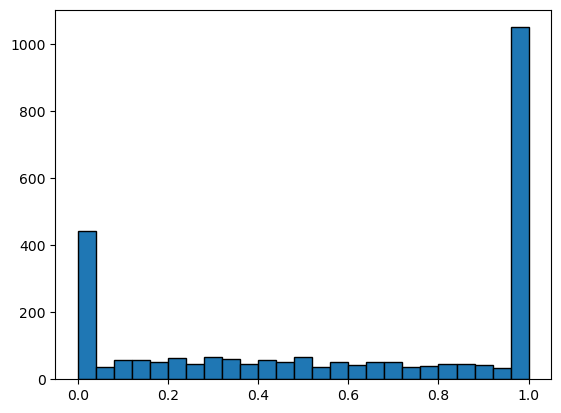

In [55]:
# Plotting thhe distribution of abundance ratios for values between 0 and 1
plt.hist(data[(data[resp_col] <= 1) & (data[resp_col] >= 0)][resp_col], bins = 25, edgecolor = 'black');

In [56]:
def four_DI_cats(ratios, neighborhood = 0):
    new_ratios = np.zeros_like(ratios).astype(str)
    
    new_ratios[ratios <= 0 + neighborhood] = 'extirpated'
    new_ratios[(ratios > 0 + neighborhood) & (ratios < 1 - neighborhood)] = 'decline'
    new_ratios[(ratios >= 1 - neighborhood) & (ratios <= 1 + neighborhood)] = 'no change'
    new_ratios[ratios > 1 + neighborhood] = 'increase'

    return new_ratios

In [57]:
# Taking a look at different possible tolerances for extirpation/no change
nbrs = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

for nbr in nbrs:
    print(f'NEIGHBORHOOD: {nbr}')
    print('-----------------')
    print(pd.Series(four_DI_cats(data[resp_col], neighborhood = nbr)).value_counts())
    print()

NEIGHBORHOOD: 0
-----------------
decline       1198
no change     1020
increase       655
extirpated     408
Name: count, dtype: int64

NEIGHBORHOOD: 0.01
-----------------
decline       1188
no change     1029
increase       650
extirpated     414
Name: count, dtype: int64

NEIGHBORHOOD: 0.02
-----------------
decline       1172
no change     1043
increase       644
extirpated     422
Name: count, dtype: int64

NEIGHBORHOOD: 0.03
-----------------
decline       1160
no change     1053
increase       639
extirpated     429
Name: count, dtype: int64

NEIGHBORHOOD: 0.04
-----------------
decline       1134
no change     1073
increase       631
extirpated     443
Name: count, dtype: int64

NEIGHBORHOOD: 0.05
-----------------
decline       1113
no change     1090
increase       624
extirpated     454
Name: count, dtype: int64

NEIGHBORHOOD: 0.1
-----------------
no change     1172
decline       1007
increase       594
extirpated     508
Name: count, dtype: int64



## Taking a look at study years

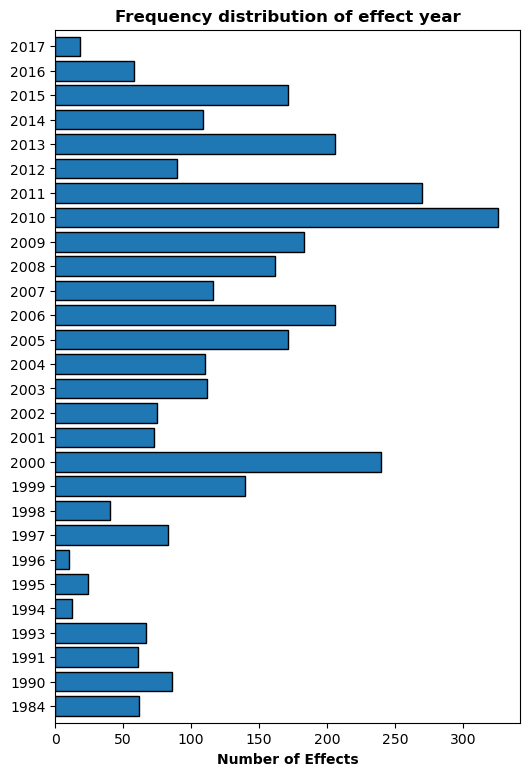

In [58]:
# By effect size
if dataset == 'mammals':
    effect_year_counts = data['Reference'].apply(extract_year).value_counts().sort_index()
    
    plt.figure(figsize = (6, 9))
    plt.barh(effect_year_counts.index.astype(str), effect_year_counts, edgecolor = 'black')
    plt.margins(y = 0.01)
    
    plt.title('Frequency distribution of effect year', weight = 'bold')
    plt.xlabel('Number of Effects', weight = 'bold');
else:
    print('Ferreiro-Arias et al. (2024) doesn\'t provide study years.')

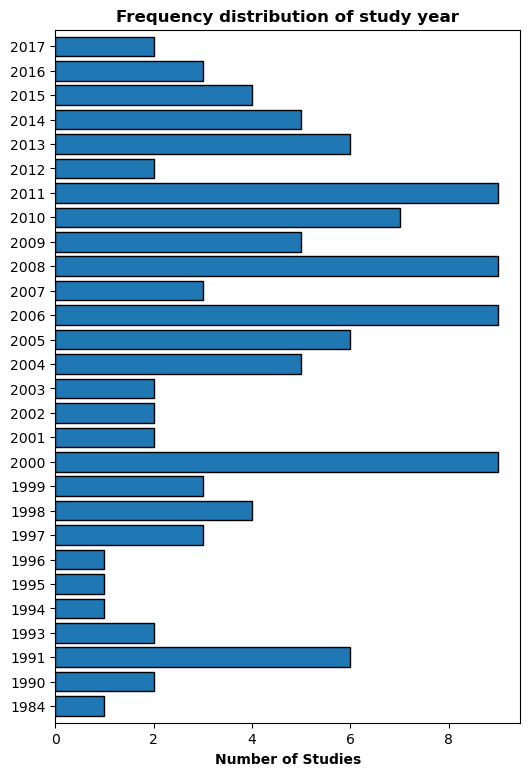

In [60]:
# By studies sizes
if dataset == 'mammals':
    study_year = pd.Series([extract_year(ref) for ref in data['Reference'].unique()])
    study_year_counts = study_year.value_counts().sort_index()
    
    plt.figure(figsize = (6, 9))
    plt.barh(study_year_counts.index.astype(str), study_year_counts, edgecolor = 'black')
    plt.margins(y = 0.01)
    
    plt.title('Frequency distribution of study year', weight = 'bold')
    plt.xlabel('Number of Studies', weight = 'bold');
else:
    print('Ferreiro-Arias et al. (2024) doesn\'t provide study years.')